# Statistical Model Fitting and Comparison

This notebook performs a comprehensive analysis to fit and compare three different mathematical models to the dataset, select the best model using AIC, and perform diagnostic analysis.

## Setup and Data Loading

In [1]:
from utils.data_loader import load_data

# Load data with normalization for improved numerical stability
df, x_mean, x_std = load_data(normalize=True)

print(f"Data loaded: {len(df)} observations")
print(f"Normalization: mean={x_mean:.4f}, std={x_std:.4f}")

Data initialized into df
Data has been normalized.
Data loaded: 50 observations
Normalization: mean=25.5000, std=14.5774


#### Q1. Find the least squares estimators of the unknown parameters under three different model assumptions

##### Model 1:
y(t) = α0 + α1 * exp(β1t) + α2 * exp(β2t) + epsilon(t)



In [2]:
import numpy as np
from scipy.optimize import curve_fit
from utils.models import model1
from utils.gauss_newton import gauss_newton_beta, X_mat, solve_alpha
import pandas as pd
import json

# Use the scaled 'x' data for fitting (improves numerical stability)
x_fit = df['x_scaled']
y_fit = df['y']

# Load initial guesses from file (generated by initial_guess_estimator.ipynb)
with open('utils/initial_guesses.json', 'r') as f:
    initial_guesses = json.load(f)
initial_guesses1 = initial_guesses['model1']

print("Initial guesses for Model 1:", initial_guesses1)
print("" + "="*70)

# --- Method 1: scipy.optimize.curve_fit (standard library method) ---
print("Fitting Model 1 with scipy.curve_fit...")
params1_cf, covariance1_cf = curve_fit(model1, x_fit, y_fit, p0=initial_guesses1, maxfev=10000)

# --- Method 2: Custom Gauss-Newton with Variable Projection ---
print("Fitting Model 1 with custom Gauss-Newton (VarPro)...")
initial_betas1 = [initial_guesses1[2], initial_guesses1[4]]  # Extract β₁ and β₂

# Run the optimizer
b_hat1, alpha_hat1, resid1, RSS1 = gauss_newton_beta(
    t = x_fit.values,
    Y = y_fit.values,
    b0 = initial_betas1,
    solve_alpha_func = solve_alpha,
    X_mat_func = X_mat,
    verbose = False  # Set to True for iteration details
)

# Reconstruct the full parameter vector in [α₀, α₁, β₁, α₂, β₂] order
params1_gn = np.array([
    alpha_hat1[0],  # α₀
    alpha_hat1[1],  # α₁
    b_hat1[0],      # β₁
    alpha_hat1[2],  # α₂
    b_hat1[1]       # β₂
])

# For consistency in the rest of the notebook, we'll use the results from curve_fit
params1 = params1_cf
covariance1 = covariance1_cf

# --- Convert scaled betas back to original units ---
# Remember: β_original = β_scaled / x_std
beta1_orig = params1[2] / x_std
beta2_orig = params1[4] / x_std

# --- Display Results ---
print("" + "="*70)
print("Model 1 (Non-linear Exponential) LSEs Comparison:")
print("="*70)

results_df1 = pd.DataFrame({
    'Parameter': ['alpha0', 'alpha1', 'beta1', 'alpha2', 'beta2', 'beta1_orig', 'beta2_orig'],
    'curve_fit': list(params1_cf) + [beta1_orig, beta2_orig],
    'gauss_newton': list(params1_gn) + [params1_gn[2]/x_std, params1_gn[4]/x_std]
})

print(results_df1.to_string(index=False))
print("="*70)

Initial guesses for Model 1: [1.7808997184724131, 0.0034026504625504976, -4.455555555555556, -0.005700626680024241, -3.911111111111111]
Fitting Model 1 with scipy.curve_fit...
Fitting Model 1 with custom Gauss-Newton (VarPro)...
Model 1 (Non-linear Exponential) LSEs Comparison:
 Parameter  curve_fit  gauss_newton
    alpha0   1.779477      1.780242
    alpha1   0.022446      0.009493
     beta1  -4.435155     -4.383090
    alpha2  -0.023820     -0.011303
     beta2  -4.368132     -4.193965
beta1_orig  -0.304249     -0.300677
beta2_orig  -0.299651     -0.287704
Fitting Model 1 with custom Gauss-Newton (VarPro)...
Model 1 (Non-linear Exponential) LSEs Comparison:
 Parameter  curve_fit  gauss_newton
    alpha0   1.779477      1.780242
    alpha1   0.022446      0.009493
     beta1  -4.435155     -4.383090
    alpha2  -0.023820     -0.011303
     beta2  -4.368132     -4.193965
beta1_orig  -0.304249     -0.300677
beta2_orig  -0.299651     -0.287704


##### Model 2:
y(t) = (α0 + α1*t) / (β0 + β1*t) + epsilon(t)

In [3]:
from utils.models import model2
from utils.gradient_descent import fit_gradient_descent

# Use the scaled 'x' data for fitting
x_fit = df['x_scaled']
y_fit = df['y']

# Load initial guesses for Model 2
with open('utils/initial_guesses.json', 'r') as f:
    initial_guesses = json.load(f)
initial_guesses2 = initial_guesses['model2']

print("Initial guesses for Model 2:", initial_guesses2)
print("" + "="*70)

# --- Method 1: scipy.optimize.curve_fit (standard library method) ---
print("Fitting Model 2 with scipy.curve_fit...")
params2_cf, covariance2_cf = curve_fit(model2, x_fit, y_fit, p0=initial_guesses2)

# --- Method 2: Custom Gradient Descent ---
print("Fitting Model 2 with custom Gradient Descent...")
lr = 1e-5          # Learning rate
num_iters = 10000  # Number of iterations

# Run the optimizer
params2_gd, RSS2_gd = fit_gradient_descent(
    x_fit.values,
    y_fit.values,
    initial_guesses2,
    lr,
    num_iters,
    verbose=False
)

# For consistency in the rest of the notebook, we'll use the results from curve_fit
params2 = params2_cf
covariance2 = covariance2_cf

# --- Display Results ---
print("" + "="*70)
print("Model 2 (Non-linear Ratio) LSEs Comparison:")
print("="*70)

results_df2 = pd.DataFrame({
    'Parameter': ['alpha0', 'alpha1', 'beta0', 'beta1'],
    'curve_fit': params2_cf,
    'gradient_descent': params2_gd
})

print(results_df2.to_string(index=False))
print("="*70)

Initial guesses for Model 2: [1.7881691857518234, 0.8268354972904384, 1.0, 0.5111962307052861]
Fitting Model 2 with scipy.curve_fit...
Fitting Model 2 with custom Gradient Descent...
Model 2 (Non-linear Ratio) LSEs Comparison:
Parameter  curve_fit  gradient_descent
   alpha0   6.516407          1.744435
   alpha1   3.385623          0.906325
    beta0   3.685190          0.986522
    beta1   2.062465          0.552119
Model 2 (Non-linear Ratio) LSEs Comparison:
Parameter  curve_fit  gradient_descent
   alpha0   6.516407          1.744435
   alpha1   3.385623          0.906325
    beta0   3.685190          0.986522
    beta1   2.062465          0.552119


##### Model 3:
y(t) = β0 + β1*t + β2*t^2 + β3*t^3 + β4*t^4 + epsilon(t)

In [4]:
from utils.models import model3_fit

# Use the original 'x' data for the polynomial model (less sensitive to scaling)
print("Fitting Model 3 (4th-degree Polynomial) with OLS...")
model3 = model3_fit(df['x'], df['y'])

print("" + "="*70)
print("Model 3 (Polynomial) LSEs:")
print("="*70)
print(model3.params)
print("="*70)

Fitting Model 3 (4th-degree Polynomial) with OLS...
Model 3 (Polynomial) LSEs:
const    3.708319
x       -0.366972
x2       0.022954
x3      -0.000570
x4       0.000005
dtype: float64


#### Q2. Describe the method used to find the LSEs and the initial guesses chosen.

**Non-linear Models (Models 1 and 2):**

Two methods were used for each non-linear model:

1. **Standard Method**: `scipy.optimize.curve_fit` - uses the Levenberg-Marquardt algorithm (a variant of the Gauss-Newton method) for non-linear least squares optimization.

2. **Custom Methods**:
   - **Model 1**: Gauss-Newton with Variable Projection (VarPro) - separates linear (α) and non-linear (β) parameters for more efficient optimization
   - **Model 2**: Gradient Descent - iterative optimization with fixed learning rate (lr=1e-5, 10,000 iterations)

**Initial Guesses:**

Initial parameter guesses were systematically determined using `initial_guess_estimator.ipynb`:
- **Model 1**: Grid search over β parameters (10×10 grid) with Variable Projection to solve for α's
- **Model 2**: Linearization technique to approximate initial parameters

The initial guesses are loaded from `utils/initial_guesses.json`:
- Model 1: [α₀, α₁, β₁, α₂, β₂] ≈ [1.78, 0.003, -4.46, -0.006, -3.91]
- Model 2: [α₀, α₁, β₀, β₁] ≈ [1.79, 0.83, 1.0, 0.51]

**Linear Model (Model 3):**

`statsmodels.api.OLS` was used for standard Ordinary Least Squares regression. No initial guesses are needed since this is a linear model that can be solved directly using the normal equations: β̂ = (XᵀX)⁻¹Xᵀy

#### Q3. Find the 'best' fitted model.

In [5]:
# Calculate RSS (Residual Sum of Squares) for each model
# Note: Use the scaled data for models 1 and 2, and original for model 3
rss1 = np.sum((df['y'] - model1(df['x_scaled'], *params1))**2)
rss2 = np.sum((df['y'] - model2(df['x_scaled'], *params2))**2)
rss3 = model3.ssr

print("="*70)
print("RESIDUAL SUM OF SQUARES (RSS)")
print("="*70)
print(f"Model 1 - curve_fit: {rss1:.6f}")
print(f"Model 1 - Gauss-Newton: {RSS1:.6f}")
print(f"Model 2 - curve_fit: {rss2:.6f}")
print(f"Model 2 - Gradient Descent: {RSS2_gd:.6f}")
print(f"Model 3 - OLS: {rss3:.6f}")

# Calculate AIC (Akaike Information Criterion) for each model
# AIC = n·ln(RSS/n) + 2k, where k is the number of parameters
n = len(df)
k1, k2, k3 = 5, 4, 5  # Number of parameters in each model

aic1 = n * np.log(rss1/n) + 2 * k1
aic2 = n * np.log(rss2/n) + 2 * k2
aic3 = n * np.log(rss3/n) + 2 * k3

print("" + "="*70)
print("AKAIKE INFORMATION CRITERION (AIC)")
print("="*70)
print(f"Model 1 (Exponential, k={k1}):    AIC = {aic1:.4f}")
print(f"Model 2 (Ratio, k={k2}):          AIC = {aic2:.4f}")
print(f"Model 3 (Polynomial, k={k3}):     AIC = {aic3:.4f}")

# Select the best model (lowest AIC)
best_model = np.argmin([aic1, aic2, aic3]) + 1
print("" + "="*70)
print(f"✓ BEST MODEL: Model {best_model} (lowest AIC)")
print("="*70)

RESIDUAL SUM OF SQUARES (RSS)
Model 1 - curve_fit: 2.536826
Model 1 - Gauss-Newton: 2.537157
Model 2 - curve_fit: 2.858002
Model 2 - Gradient Descent: 2.858002
Model 3 - OLS: 3.030750
AKAIKE INFORMATION CRITERION (AIC)
Model 1 (Exponential, k=5):    AIC = -139.0555
Model 2 (Ratio, k=4):          AIC = -135.0950
Model 3 (Polynomial, k=5):     AIC = -130.1606
✓ BEST MODEL: Model 1 (lowest AIC)


#### Q4. Find the estimate of σ²

The error variance σ² represents the variance of the random error term ε(t) in our model. We estimate it using the residual sum of squares (RSS) divided by the degrees of freedom.

In [6]:
# Estimate of σ² (error variance) for the best model
# Formula: σ̂² = RSS / (n - k)
n = len(df)

if best_model == 1:
    sigma2_est = rss1 / (n - k1)
    model_name = "Model 1 (Non-linear Exponential)"
elif best_model == 2:
    sigma2_est = rss2 / (n - k2)
    model_name = "Model 2 (Non-linear Ratio)"
else:
    sigma2_est = rss3 / (n - k3)
    model_name = "Model 3 (4th-degree Polynomial)"

print("="*70)
print("ERROR VARIANCE ESTIMATE")
print("="*70)
print(f"Best Model: {model_name}")
print(f"Estimated σ²: {sigma2_est:.6f}")
print(f"Estimated σ:  {np.sqrt(sigma2_est):.6f}")
print("="*70)

ERROR VARIANCE ESTIMATE
Best Model: Model 1 (Non-linear Exponential)
Estimated σ²: 0.056374
Estimated σ:  0.237432


#### Q5. Find the associated confidence intervals based on the Fisher information matrix

Confidence intervals provide a range of plausible values for each parameter. We use the covariance matrix (which is related to the inverse of the Fisher information matrix) to compute standard errors, then construct intervals using the t-distribution.

In [7]:
# 95% Confidence Intervals for the best model parameters
# Formula: θ̂ᵢ ± t(α/2, n-k) × SE(θ̂ᵢ)
# where SE(θ̂ᵢ) = √(σ̂² × Cᵢᵢ) and Cᵢᵢ is the i-th diagonal element of (XᵀX)⁻¹

from scipy.stats import t

# Degrees of freedom
if best_model == 1:
    params = params1
    covariance = covariance1
    dof = n - k1
    param_names = ['α₀', 'α₁', 'β₁', 'α₂', 'β₂']
elif best_model == 2:
    params = params2
    covariance = covariance2_cf  # Use scipy's covariance from curve_fit
    dof = n - k2
    param_names = ['α₀', 'α₁', 'β₀', 'β₁']
else:
    params = model3.params.values
    # For Model 3, calculate covariance manually
    covariance = sigma2_est * np.linalg.inv(model3.model.exog.T @ model3.model.exog)
    dof = n - k3
    param_names = ['β₀', 'β₁', 'β₂', 'β₃', 'β₄']

# Critical t-value for 95% CI
alpha = 0.05
t_val = t.ppf(1 - alpha/2, dof)

# Standard errors = sqrt(diagonal of covariance matrix)
se = np.sqrt(np.diag(covariance))

# Confidence intervals
ci = np.column_stack([params - t_val * se, params + t_val * se])

print("="*70)
print("95% CONFIDENCE INTERVALS FOR BEST MODEL PARAMETERS")
print("="*70)
print(f"Model: {model_name}")
print(f"Degrees of freedom: {dof}")
print(f"Critical t-value: {t_val:.4f}")
print("-"*70)
for i, p_name in enumerate(param_names):
    print(f"{p_name:>4s}: [{ci[i,0]:10.6f}, {ci[i,1]:10.6f}]  (Estimate: {params[i]:10.6f})")
print("="*70)

95% CONFIDENCE INTERVALS FOR BEST MODEL PARAMETERS
Model: Model 1 (Non-linear Exponential)
Degrees of freedom: 45
Critical t-value: 2.0141
----------------------------------------------------------------------
  α₀: [  1.680417,   1.878536]  (Estimate:   1.779477)
  α₁: [-1060.886046, 1060.930938]  (Estimate:   0.022446)
  β₁: [-1522.816638, 1513.946328]  (Estimate:  -4.435155)
  α₂: [-1060.863884, 1060.816244]  (Estimate:  -0.023820)
  β₂: [-1574.705805, 1565.969540]  (Estimate:  -4.368132)


#### Q6. Find the residuals

Residuals are the differences between the observed values and the fitted values. They help us assess the quality of the fit and check model assumptions. For a good model, residuals should be randomly scattered around zero.

In [8]:
# Calculate residuals for the best model
# Residuals: ε̂ᵢ = yᵢ - ŷᵢ
if best_model == 1:
    y_fit = model1(df['x'], *params1)
elif best_model == 2:
    y_fit = model2(df['x'], *params2)
else:
    # For Model 3, use the fitted values directly from statsmodels
    y_fit = model3.fittedvalues

resid1 = df['y'] - y_fit

print("="*70)
print("RESIDUALS FOR BEST MODEL")
print("="*70)
print(f"Model: {model_name}")
print(f"Number of residuals: {len(resid1)}")
print(f"Mean of residuals: {resid1.mean():.8f} (should be ≈ 0)")
print(f"Standard deviation: {resid1.std():.6f}")
print(f"Min residual: {resid1.min():.6f}")
print(f"Max residual: {resid1.max():.6f}")
print("="*70)

RESIDUALS FOR BEST MODEL
Model: Model 1 (Non-linear Exponential)
Number of residuals: 50
Mean of residuals: 0.11645954 (should be ≈ 0)
Standard deviation: 0.433033
Min residual: -0.273369
Max residual: 1.837347


#### Q7. Test the normality assumption of the residuals

Many statistical procedures assume that residuals are normally distributed. We use the Shapiro-Wilk test to formally test this assumption. If the test fails, it may indicate that the model is not appropriate or that transformations are needed.

In [14]:
# Shapiro-Wilk Test for Normality of Residuals
# H₀: Residuals are normally distributed
# H₁: Residuals are NOT normally distributed
# Decision: Reject H₀ if p-value < α (typically 0.05)

from scipy.stats import shapiro

stat, p = shapiro(resid1)

print("="*70)
print("SHAPIRO-WILK NORMALITY TEST")
print("="*70)
print(f"Test Statistic (W): {stat:.6f}")
print(f"P-value: {p:.6f}")
print("-"*70)
if p > 0.05:
    print("✓ PASS: Residuals appear to be normally distributed (p > 0.05)")
    print("  → The model assumptions are satisfied.")
else:
    print("✗ FAIL: Residuals may NOT be normally distributed (p ≤ 0.05)")
    print("  → Consider transforming the data or using a different model.")
print("="*70)

SHAPIRO-WILK NORMALITY TEST
Test Statistic (W): 0.746621
P-value: 0.000000
----------------------------------------------------------------------
✗ FAIL: Residuals may NOT be normally distributed (p ≤ 0.05)
  → Consider transforming the data or using a different model.


#### Q8. Plot the observed data points and the fitted curve for the best model

Visual inspection is crucial for understanding how well the model fits the data. We create two plots:
1. **Fitted curve**: Shows the observed data points and the smooth fitted curve
2. **Residual plot**: Shows residuals vs fitted values to check for patterns (heteroscedasticity, non-linearity, etc.)

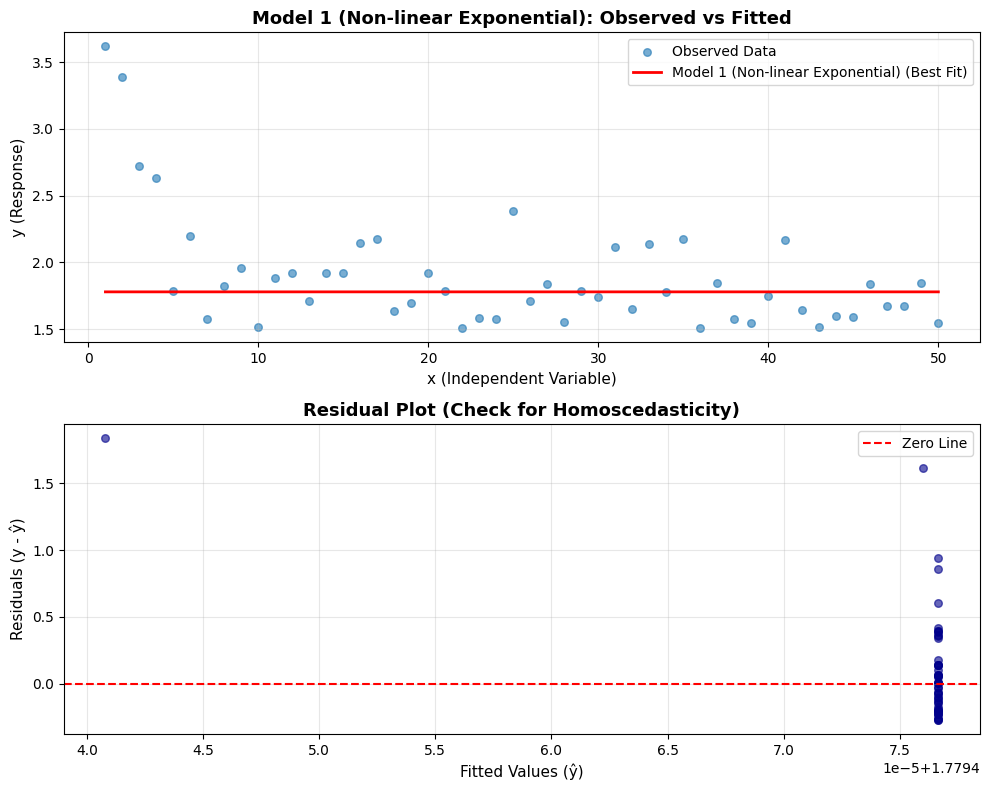

In [10]:
# Final visualization: Data, Fitted Model, and Residual Plot
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot 1: Data and fitted model
ax1.scatter(df['x'], df['y'], alpha=0.6, label='Observed Data', s=30)
x_smooth = np.linspace(df['x'].min(), df['x'].max(), 500)

if best_model == 1:
    y_smooth = model1(x_smooth, *params1)
elif best_model == 2:
    y_smooth = model2(x_smooth, *params2)
else:
    # For Model 3, evaluate polynomial
    y_smooth = sum(model3.params[i] * x_smooth**i for i in range(k3))

ax1.plot(x_smooth, y_smooth, 'r-', linewidth=2, label=f'{model_name} (Best Fit)')
ax1.set_xlabel('x (Independent Variable)', fontsize=11)
ax1.set_ylabel('y (Response)', fontsize=11)
ax1.set_title(f'{model_name}: Observed vs Fitted', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residual plot
# Use fitted values at observed data points (not the smooth curve)
if best_model == 1:
    y_fitted_observed = model1(df['x'], *params1)
elif best_model == 2:
    y_fitted_observed = model2(df['x'], *params2)
else:
    y_fitted_observed = model3.fittedvalues

ax2.scatter(y_fitted_observed, resid1, alpha=0.6, s=30, c='darkblue')
ax2.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Line')
ax2.set_xlabel('Fitted Values (ŷ)', fontsize=11)
ax2.set_ylabel('Residuals (y - ŷ)', fontsize=11)
ax2.set_title('Residual Plot (Check for Homoscedasticity)', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Save the plot for the report
import os
os.makedirs('Images', exist_ok=True)
fig.savefig('Images/obsVSfit.png', dpi=300, bbox_inches='tight')
print("✓ Plot saved to Images/obsVSfit.png")

✓ Plot saved to Images/obsVSfit.png


---

**Author**: Manas Jain Kuniya (Roll Number: 230626)  
**Course**: MTH686 - Non-Linear Regression  
**Dataset**: set-76.dat